In [1]:
import os
import sys
import argparse
import joblib

PYMO_DIR = os.path.join('/home/serverai/ltdoanh/Motion_Diffusion', 'datasets', 'pymo')
if PYMO_DIR not in sys.path:
    sys.path.insert(0, PYMO_DIR)

import torch
import numpy as np

fig = 3

In [2]:
scale_factor_path = "./checkpoints/beat/VQKL_Enhanced_BEAT/scale_factor.txt" 
scale_val = None

print(f"Đang đọc giá trị từ {scale_factor_path}...")

if os.path.exists(scale_factor_path):
    with open(scale_factor_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if line.strip().startswith("scale_factor"):
                parts = line.split('=')
                if len(parts) > 1:
                    val_str = parts[1].strip()
                    try:
                        scale_val = float(val_str)
                        print(f"--> Tìm thấy scale_factor: {scale_val}")
                    except ValueError:
                        print(f"--> LỖI: Không thể chuyển '{val_str}' sang float.")
                        scale_val = None
                break
else:
    print(f"LỖI: Không tìm thấy file {scale_factor_path}. Vui lòng kiểm tra lại đường dẫn.")
    exit(1) 

if scale_val is None:
    print("LỖI: Không đọc được giá trị scale_factor trong file.")
    exit(1)

Đang đọc giá trị từ ./checkpoints/beat/VQKL_Enhanced_BEAT/scale_factor.txt...
--> Tìm thấy scale_factor: 1.57079887


In [3]:
class Config:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    checkpoints_dir = "./checkpoints"
    dataset_name = 'beat'
    
    vqkl_name = 'VQKL_Enhanced_BEAT'  
    
    diffusion_name = 'vqkl_diff_sobolev_phys' 
    
    checkpoint_name = 'best_model.pt' 
    result_dir = "./results"

    scale_factor = scale_val

    latent_dim = 512
    num_layers = 8
    num_heads = 8
    ff_size = 1024
    dropout = 0.2    
    no_eff = False  
    freeze_vqkl = True

    use_kl_posterior = True 

    diffusion_steps = 1000
    noise_schedule = 'linear' 
    
    sampler = 'ddim'
    ddim_eta = 0.0 
    
    guidance_scale = 4.0

class ClassifierFreeGuidanceModel(torch.nn.Module):
    def __init__(self, model, guidance_scale):
        super().__init__()
        self.model = model
        self.guidance_scale = guidance_scale

    def forward(self, x, t, y=None):
        if self.guidance_scale == 1.0:
            return self.model(x, t, y)

        texts = y['text']
        lengths = y['length']
        batch_size = len(texts)

        uncond_texts = [""] * batch_size

        x_in = torch.cat([x, x], dim=0)

        t_in = torch.cat([t, t], dim=0)

        y_in = {
            'text': texts + uncond_texts,  
            'length': lengths + lengths   
        }

        model_output = self.model(x_in, t_in, y=y_in)

        eps_cond, eps_uncond = model_output.chunk(2, dim=0)

        eps = eps_uncond + self.guidance_scale * (eps_cond - eps_uncond)

        return eps

from models.vq_diffusion import create_vqkl_latent_diffusion, VQKLLatentDiffusionWrapper
from models.gaussian_diffusion import (
    GaussianDiffusion, get_named_beta_schedule,
    ModelMeanType, ModelVarType, LossType
)

def load_models(args):
    print("\nLoading model...")

    model = create_vqkl_latent_diffusion(
        dataset_name=args.dataset_name,
        vqkl_name=args.vqkl_name,
        checkpoints_dir=args.checkpoints_dir,
        device=args.device,
        freeze_vqkl=args.freeze_vqkl,
        scale_factor=args.scale_factor,

        use_kl_posterior=args.use_kl_posterior, 
        
        latent_dim=args.latent_dim,
        num_layers=args.num_layers,
        num_heads=args.num_heads,
        ff_size=args.ff_size,
        dropout=args.dropout,
        no_eff=args.no_eff
    )

    checkpoint_path = os.path.join(
        args.checkpoints_dir,
        args.dataset_name,
        args.diffusion_name, 
        'model',
        args.checkpoint_name
    )

    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")

    print(f"Loading checkpoint: {checkpoint_path}")
    
    try:
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
    except Exception:
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

    try:
        model.load_state_dict(checkpoint['model_state_dict'], strict=True)
        print("Checkpoint loaded (strict)")
    except Exception as e:
        print(f"Strict loading failed: {e}")
        print("Retrying with strict=False (Missing keys might be acceptable usually VQ parts)...")
        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        print("Checkpoint loaded (loose)")

    model.eval()

    betas = get_named_beta_schedule(args.noise_schedule, args.diffusion_steps)
    diffusion = GaussianDiffusion(
        betas=betas,
        model_mean_type=ModelMeanType.EPSILON, 
        model_var_type=ModelVarType.FIXED_SMALL,
        loss_type=LossType.RESCALED_L1, 
        rescale_timesteps=False
    )

    print("Model and diffusion ready")
    return model, diffusion

@torch.no_grad()
def generate_motion(model, diffusion, text_prompts, lengths, args, mean, std):
    """Generate motion from text with CFG"""
    
    print(f"\n Generating motion for {len(text_prompts)} prompts...")
    print(f"   Guidance Scale: {args.guidance_scale}")

    raw_wrapped_model = VQKLLatentDiffusionWrapper(model)
    cfg_model = ClassifierFreeGuidanceModel(raw_wrapped_model, args.guidance_scale)
    
    B = len(text_prompts)
    T_latent = model.num_frames
    latent_dim = getattr(model.vqkl, 'embed_dim', model.vqkl.code_dim)
    
    shape = (B, T_latent, latent_dim)
    
    model_kwargs = {
        'y': {
            'text': text_prompts,
            'length': lengths,
        }
    }
    
    if args.sampler == 'ddim':
        print(f"Sampling with DDIM (eta={args.ddim_eta})...")
        latent_samples = diffusion.ddim_sample_loop(
            cfg_model,
            shape,
            clip_denoised=False,
            model_kwargs=model_kwargs,
            device=args.device,
            progress=True,
            eta=args.ddim_eta
        )
    else:
        print("Sampling with DDPM...")
        latent_samples = diffusion.p_sample_loop(
            cfg_model, 
            shape,
            clip_denoised=False,
            model_kwargs=model_kwargs,
            device=args.device,
            progress=True
        )
    
    print(f"Latent shape: {latent_samples.shape}")
    
    print("Decoding to motion...")
    motion = model.decode_from_latent(latent=latent_samples)
    
    print(f"Motion shape: {motion.shape}")
    
    motion_np = motion.cpu().numpy()
    if motion_np.shape[1] == 264:
        motion_np = motion_np.transpose(0, 2, 1)
    
    motion_denorm = motion_np * std + mean
    
    print(f" Generation complete: {motion_denorm.shape}")
    
    return motion_denorm

def main():
    args = Config()
    stats_path = os.path.join('/home/serverai/ltdoanh/Motion_Diffusion', 'global_pipeline.pkl')
    
    print(f"Loading stats from: {stats_path}")
    pipeline = joblib.load(stats_path)
    scaler = pipeline.named_steps['stdscale']
    mean = scaler.data_mean_
    std = scaler.data_std_
    print(f" Stats loaded (dim={len(mean)})")

    model, diffusion = load_models(args)
    
    text_prompts = [
        "the first thing i like to do on weekends is relaxing and i'll go shopping if i'm not that tired",
    ]
    
    lengths = [45] * len(text_prompts)
    
    motion = generate_motion(model, diffusion, text_prompts, lengths, args, mean, std)
    
    os.makedirs(args.result_dir, exist_ok=True)
    save_path = os.path.join(args.result_dir, f'vqkl_diffusion_hierarchical_v{fig}.npy')
    np.save(save_path, motion)
    
    print(f" Saved to: {save_path}")
    print("\n" + "="*60)
    print("INFERENCE COMPLETED!")
    print("="*60)

if __name__ == "__main__":
    main()

Loading stats from: /home/serverai/ltdoanh/Motion_Diffusion/global_pipeline.pkl
 Stats loaded (dim=264)

Loading model...
[INFO] Using scale_factor=1.570799 for latent normalization
[INFO] KL posterior mode: True
Loading VQ-KL from ./checkpoints/beat/VQKL_Enhanced_BEAT/model/best_model.tar
VQ-KL loaded successfully
VQ-KL frozen


/srv/conda/envs/serverai/motion_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


VQKLLatentDiffusion initialized:
  - Input features: 512
  - Latent seq length: 45
  - Transformer latent dim: 512
  - Scale factor: 1.570799
Loading checkpoint: ./checkpoints/beat/vqkl_diff_sobolev_phys/model/best_model.pt
Checkpoint loaded (strict)
Model and diffusion ready


/srv/conda/envs/serverai/motion_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



 Generating motion for 1 prompts...
   Guidance Scale: 4.0
Sampling with DDIM (eta=0.0)...


100%|██████████| 1000/1000 [01:04<00:00, 15.46it/s]


Latent shape: torch.Size([1, 45, 512])
Decoding to motion...
Motion shape: torch.Size([1, 360, 264])
 Generation complete: (1, 360, 264)
 Saved to: ./results/vqkl_diffusion_hierarchical_v3.npy

INFERENCE COMPLETED!


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
import os
import numpy as np
import joblib
import pandas as pd

# Setup path
PYOM_DIR = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/pymo"
if PYOM_DIR not in sys.path:
    sys.path.insert(0, PYOM_DIR)

from pymo.parsers import BVHParser
from pymo.viz_tools import draw_stickfigure, draw_stickfigure3d


from sklearn.pipeline import Pipeline

pipeline_path = "/home/serverai/ltdoanh/Motion_Diffusion/global_pipeline.pkl"
print(f"📦 Loading pipeline from: {pipeline_path}")
pipeline = joblib.load(pipeline_path)

ref_bvh_path = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/2_scott_0_55_55.bvh"

if os.path.exists(ref_bvh_path):
    print(f"🔧 Processing reference BVH: {os.path.basename(ref_bvh_path)}")
    parser = BVHParser()
    ref_data = parser.parse(ref_bvh_path)
    
    steps_before_np = []
    np_found = False
    
    for name, step in pipeline.steps:
        if name == 'np': 
            np_found = True
            break
        steps_before_np.append((name, step))
    
    if np_found and steps_before_np:
        print(f"   Running reference data through pre-processing steps: {[n for n, _ in steps_before_np]}...")
        
        pre_pipeline = Pipeline(steps_before_np)
        
        processed_ref = pre_pipeline.fit_transform([ref_data])
        
        template_data = processed_ref[0]
        
        print(f"   Template shape after preprocessing: {template_data.values.shape}") 
        
        if template_data.values.shape[1] == 264:
            # Gán template đúng shape vào Numpyfier
            pipeline.named_steps['np'].org_mocap_ = template_data
            print("  Skeleton structure injected with CORRECT dimensions (264)!")
        else:
            print(f" Warning: Processed shape is {template_data.values.shape[1]}, but model output is 264.")
            print("   Visualization might still fail.")
            
    else:
        print(" Could not isolate steps before Numpyfier.")
        pipeline.named_steps['np'].org_mocap_ = ref_data

else:
    print(f" Reference BVH not found at {ref_bvh_path}")
    sys.exit(1)

📦 Loading pipeline from: /home/serverai/ltdoanh/Motion_Diffusion/global_pipeline.pkl
🔧 Processing reference BVH: 2_scott_0_55_55.bvh
   Running reference data through pre-processing steps: ['param', 'rcpn', 'delta', 'const']...
   Template shape after preprocessing: (3720, 264)
  Skeleton structure injected with CORRECT dimensions (264)!



 Loading motion: /home/serverai/ltdoanh/Motion_Diffusion/results/vqkl_diffusion_hierarchical_v3.npy
   Raw Input Shape: (360, 264)
   Raw Input Range: -1090.90 to 1139.81
 Detected large values (Real-scale data). Re-normalizing for pipeline compatibility...
   Normalized Range: -256.54 to 200.37

 Performing inverse transform...
positions 2 eulers is not supported
    Inverse transform successful!
   Final Motion Range (cm): -5897.70 to 1139.81

 Visualizing Frame 59...


<Figure size 1000x800 with 0 Axes>

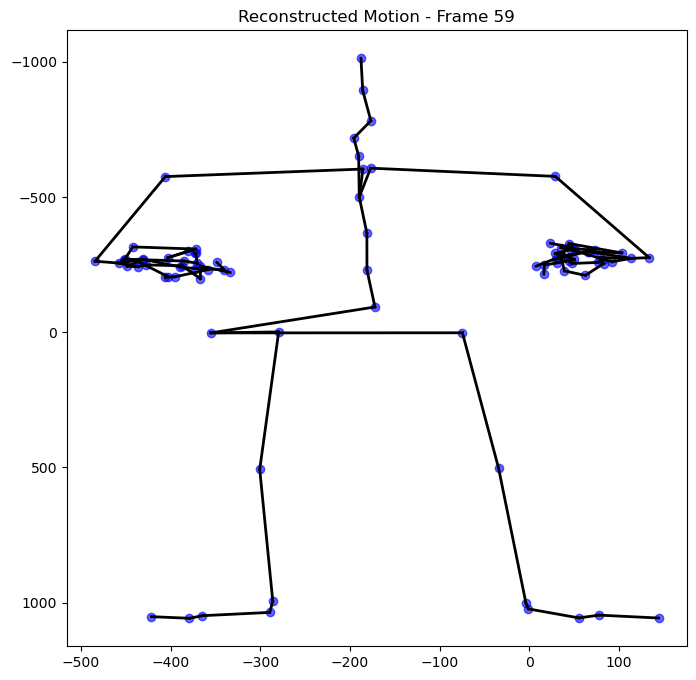

In [5]:
npy_path = f"/home/serverai/ltdoanh/Motion_Diffusion/results/vqkl_diffusion_hierarchical_v{fig}.npy"
print(f"\n Loading motion: {npy_path}")
motion_data = np.load(npy_path)

if motion_data.ndim == 3:
    motion_data = motion_data[0]

print(f"   Raw Input Shape: {motion_data.shape}")
print(f"   Raw Input Range: {motion_data.min():.2f} to {motion_data.max():.2f}")

scaler = pipeline.named_steps['stdscale']
mean = scaler.data_mean_
std = scaler.data_std_

if np.abs(motion_data).max() > 100:
    print(" Detected large values (Real-scale data). Re-normalizing for pipeline compatibility...")
    motion_data = (motion_data - mean) / std
    print(f"   Normalized Range: {motion_data.min():.2f} to {motion_data.max():.2f}")
else:
    print(" Data seems to be already normalized.")

print("\n Performing inverse transform...")
try:
    reconstructed = pipeline.inverse_transform([motion_data])
    mocap_data = reconstructed[0]
    
    print("    Inverse transform successful!")
    
    df = mocap_data.values
    print(f"   Final Motion Range (cm): {df.min().min():.2f} to {df.max().max():.2f}")
    
    frame = 59
    print(f"\n Visualizing Frame {frame}...")
    
    plt.figure(figsize=(10, 8)) 
    draw_stickfigure(mocap_data, frame=frame)
    plt.gca().invert_yaxis()
    plt.title(f"Reconstructed Motion - Frame {frame}")
    plt.show()
    
except Exception as e:
    print(f"\n ERROR during visualization: {e}")
    import traceback
    traceback.print_exc()